Demonstrate basic functionality of firmware on ZCU111

Loop back from DAC_229_T1_CH2 to ADC_224_T0_CH0

In [1]:
import sys
#sys.path.append('../qick/qick_lib/')

from mkids_4x4096_v4 import *

import numpy as np

import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift

In [2]:
# Load bitstream with custom overlay
soc = TopSoc('./mkids_4x4096_v4.bit', ignore_version=True, force_init_clks=False)

In [3]:
def freq2ch(fs, f, N):   
    # Channel center.
    fc = fs/N
    
    k = round(f/fc)
    
    return int(np.mod(k+N/2,N))

def ch2freq(fs, k, N):     
    # Channel center.
    fc = fs/N
    
    if k >= N/2:
        return k*fc - fs/2
    else:
        return k*fc + fs/2

In [4]:
###########################
### Configure DDS + CIC ###
###########################
# By-pass DDS product.
soc.ddscic.dds_outsel(outsel="input")

# Set Decimation value.
soc.ddscic.decimation(4)

# Set DDS frequency.
#for i in range(soc.ddscic.NCH_TOTAL):
#    soc.ddscic.set_ddsfreq(ch_id=i, f=80e3)

In [5]:
########################################
### Set output frequency using SG V6 ###
########################################
# Frequency.
#fout = 1124.1
#g = 0.5
#soc.gen.set(f=fout,g=g)

In [7]:
#########################################
### Set output frequency with DDS+PFB ###
#########################################
# DAC tile and block.
tile = soc.dacs['12']['tile']
block = soc.dacs['12']['block']

# Mixer frequency.
fmix = 1024
soc.mixer.set_freq(tile=tile, dac=block, f=fmix)

# All channels off.
soc.dds_out.alloff()

# Frequency.
fout = 1124.1
g = 0.5

# Frequency of PFB output (delta).
fout_pfb = fout - fmix

# Channel number.
K = int(np.round(fout_pfb/soc.pfb_out.get_fc()))

# DDS frequency.
fdds = (fout_pfb - K*soc.pfb_out.get_fc())#  external frequencies in MHz 
soc.dds_out.ddscfg(f=fdds,g=g,ch=K)

print('fout = {:.3f}, fout (PFB) = {:.3f}, K = {}, fdds = {:.3f}'.format(fout,fout_pfb,K,fdds))


#############################
### Set DDS frequencies ###
#############################
#chlist = [0]
#chlist = np.arange(500)
#chlist = np.arange(soc.dds_out.NCH_TOTAL)
#for ch in chlist:
    #soc.dds_out.ddscfg(f=0, g=0.004, ch=ch)
    #print('f = {}'.format(ch*soc.fc0 + 1000))

# Set output quantization.
soc.pfb_out.qout(1)

# Move one channel a bit...
#soc.dds_out.ddscfg(f=80e3+150, g=0.2, ch=6)

# Set some noise...
#soc.dds_out.ddscfg(f=0, g=0.1, ch=1, sel="noise")
#soc.dds_out.ddscfg(f=0, g=0.1, ch=9, sel="noise")

fout = 1124.100, fout (PFB) = 100.100, K = 50, fdds = 0.100


Phase = -2.790


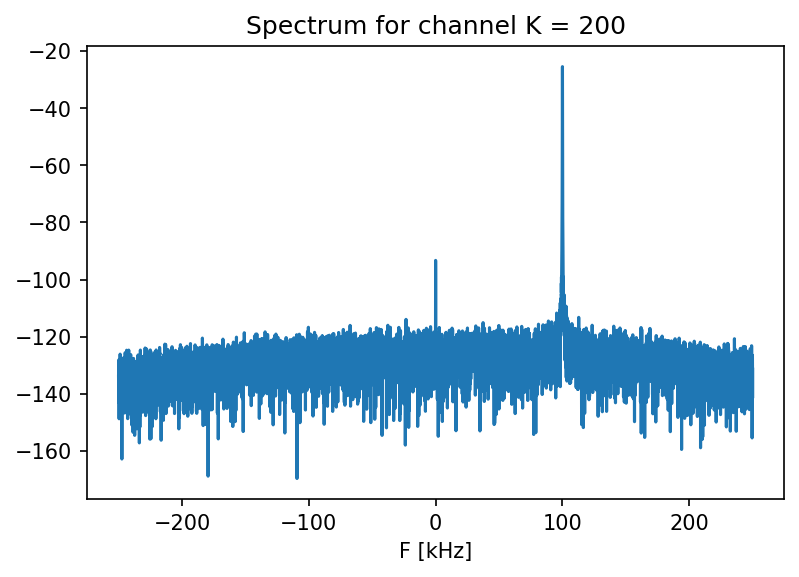

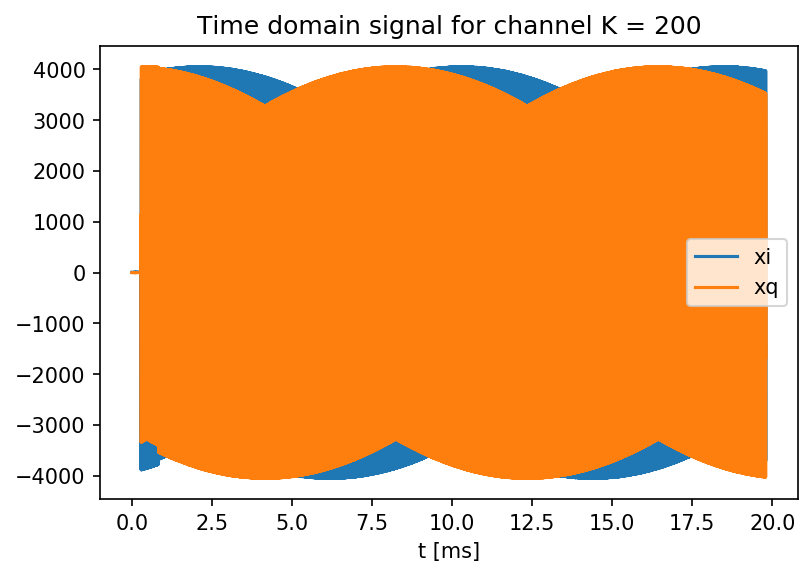

In [8]:
###########################
### Plot single channel ###
###########################
soc.pfb_in.qout(8)

# Set Decimation value.
soc.ddscic.decimation(value=2)

# By-pass DDS product.
soc.ddscic.dds_outsel(outsel="input")

# Channel's sampling frequency.
fs = soc.pfb_in.get_fb()/soc.ddscic.get_decimate()

# Channel number.
K = freq2ch(fs=soc.pfb_in.get_fs(), f=fout, N=soc.pfb_in.N)
#K = 36

# Un-mask channel.
soc.chsel.set_single(K)

# Set DDS frequency.
soc.ddscic.set_ddsfreq(ch_id=K, f=30e3)

# Transfer data.
[xi,xq] = soc.stream.get_data(nt=1,idx=soc.chsel.ch2idx(K))
xi = xi[100:]
xq = xq[100:]
x = xi + 1j*xq

i0 = 1000
i1 = -1000
iMean = xi[i0:i1].mean()
qMean = xq[i0:i1].mean()
fi = np.angle(iMean + 1j*qMean)
print('Phase = {:.3f}'.format(fi))

NF = (2**15)*len(x)

w = np.hanning(len(x))
xw = x*w
F = (np.arange(len(x))/len(x)-0.5)*fs*1000
Y = fftshift(fft(xw))

plt.figure(1,dpi=150)
plt.plot(F,20*np.log10(abs(Y)/NF))
plt.title("Spectrum for channel K = %d" %K);
plt.xlabel("F [kHz]");
#plt.xlim([0,25])

# Time domain signal.
ts = 1/(fs*1000)
t = ts*np.arange(len(xi))
n = np.arange(len(xi))

# Phase jump.
xj_phi = np.arccos(xi[0]/np.max(np.abs(xi)))
xj_phi_jump = 2*np.pi*(soc.gen.get()-1124)*4*1000
xj = np.max(np.abs(xi))*np.cos(2*np.pi*(soc.gen.get()-1124)*n*ts*1000 + xj_phi)
xj_jump = np.max(np.abs(xi))*np.cos(2*np.pi*(soc.gen.get()-1124)*n*ts*1000 + xj_phi + xj_phi_jump)

plt.figure(2,dpi=150)
plt.plot(t,xi)
plt.plot(t,xq)
plt.legend(['xi','xq'])
plt.title("Time domain signal for channel K = %d" %K);
plt.xlabel("t [ms]");
#plt.xlim([100,200]);

Iteration K = 0
Iteration K = 1
Iteration K = 2
Iteration K = 3
Iteration K = 4
Iteration K = 5
Iteration K = 6
Iteration K = 7
Iteration K = 8
Iteration K = 9


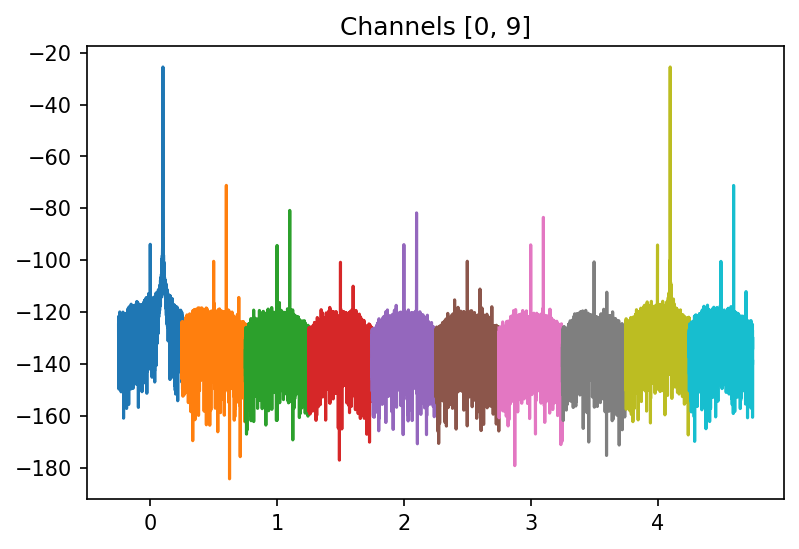

In [9]:
#############################
### Channels Side-by-Side ###
#############################
# Quantization.
soc.pfb_in.qout(8)

# Set Decimation value.
soc.ddscic.decimation(value=2)

# By-pass DDS product.
soc.ddscic.dds_outsel(outsel="input")

# Channel's sampling frequency.
fs = soc.pfb_in.get_fb()/soc.ddscic.get_decimate()

# Channels to plot.
#K = np.arange(soc.pfb_in.N)
K = np.arange(0,10)

plt.figure(dpi=150)

# Frequency and amplitude vectors.
FF = []
AA = []
for KK in K:
    print("Iteration K = %d" %KK)
    fck = KK*soc.pfb_in.get_fc()
    
    # Transfer data.
    [xi,xq] = soc.stream.get_data(nt=1,idx=soc.chsel.ch2idx(KK))
    x = xi + 1j*xq
    
    # Frequency vector.
    F = (np.arange(len(x))/len(x)-0.5)*fs
    
    # Normalization factor.
    NF = (2**15)*len(F)

    w = np.hanning(len(x))
    xw = x*w
    YY = fftshift(fft(xw))
    YYlog = 20*np.log10(abs(YY)/NF)
    AA = np.concatenate((AA,YYlog))
    
    Fk = F+fck
    FF = np.concatenate((FF,Fk))
    plt.plot(Fk,YYlog)
    
# Plot results.
#plt.plot(FF,AA)

# Save figure.
plt.title("Channels [%d, %d]" %(min(K),max(K)))
fn = "pfb_" + str(soc.pfb_in.N) + "_ch_" + str(min(K)) + "_" + str(max(K)) + ".pdf"
#plt.savefig(fn)

Input DF: 15.2587890625 Hz, Output DF: 0.95367431640625 Hz
Ratio: 16.0

i = 0, fin = 200.0000 MHz, fdds = 00.00 kHz, K = 2448, fout = 200.00 MHz, fi = -2.232, fi0 =  0.000
i = 1, fin = 200.1001 MHz, fdds = 100.10 kHz, K = 2448, fout = 200.10 MHz, fi = -2.346, fi0 =  0.000
i = 2, fin = 200.2002 MHz, fdds = 200.20 kHz, K = 2448, fout = 200.20 MHz, fi = -2.369, fi0 =  0.000
i = 3, fin = 200.3003 MHz, fdds = -199.71 kHz, K = 2449, fout = 200.30 MHz, fi = -2.389, fi0 =  0.000
i = 4, fin = 200.4004 MHz, fdds = -99.61 kHz, K = 2449, fout = 200.40 MHz, fi = -2.343, fi0 =  0.000
i = 5, fin = 200.5005 MHz, fdds = 00.49 kHz, K = 2449, fout = 200.50 MHz, fi = -2.363, fi0 =  0.000
i = 6, fin = 200.6006 MHz, fdds = 100.59 kHz, K = 2449, fout = 200.60 MHz, fi = -2.355, fi0 =  0.000
i = 7, fin = 200.7007 MHz, fdds = 200.70 kHz, K = 2449, fout = 200.70 MHz, fi = -2.350, fi0 =  0.000
i = 8, fin = 200.8008 MHz, fdds = -199.20 kHz, K = 2450, fout = 200.80 MHz, fi = -2.344, fi0 =  0.000
i = 9, fin = 200.90

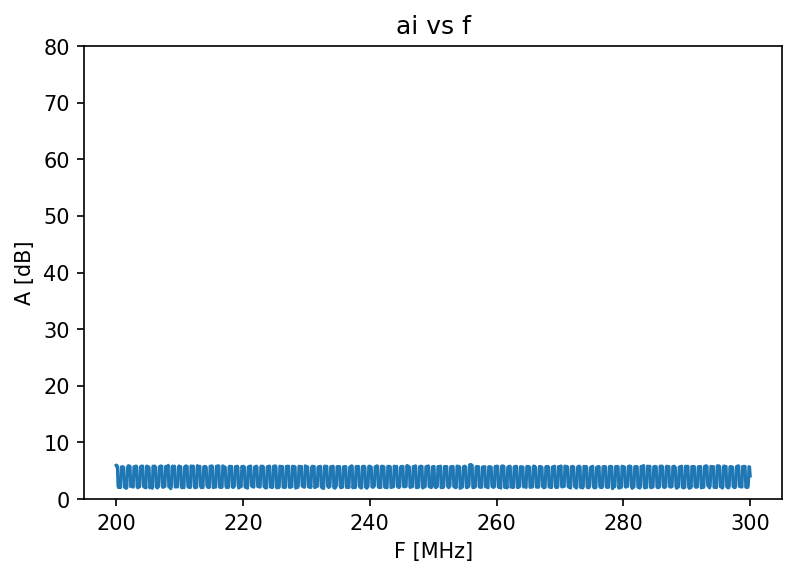

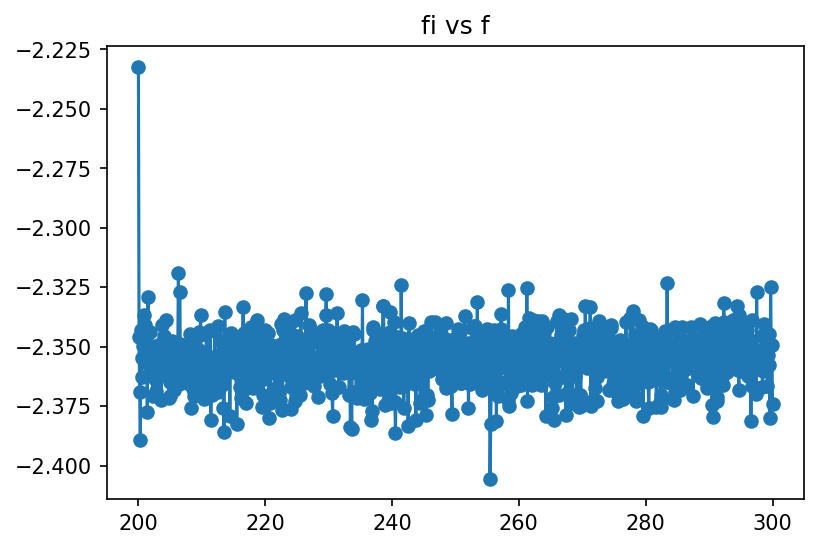

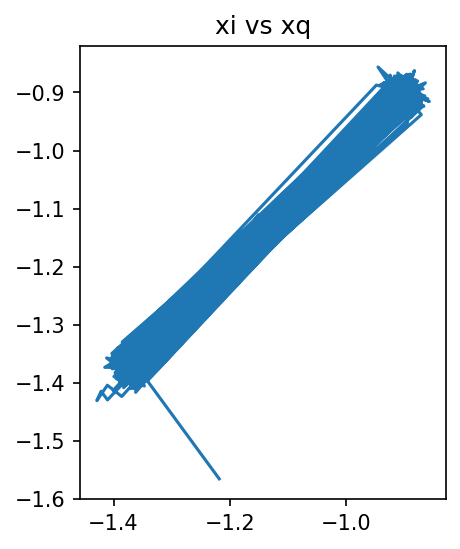

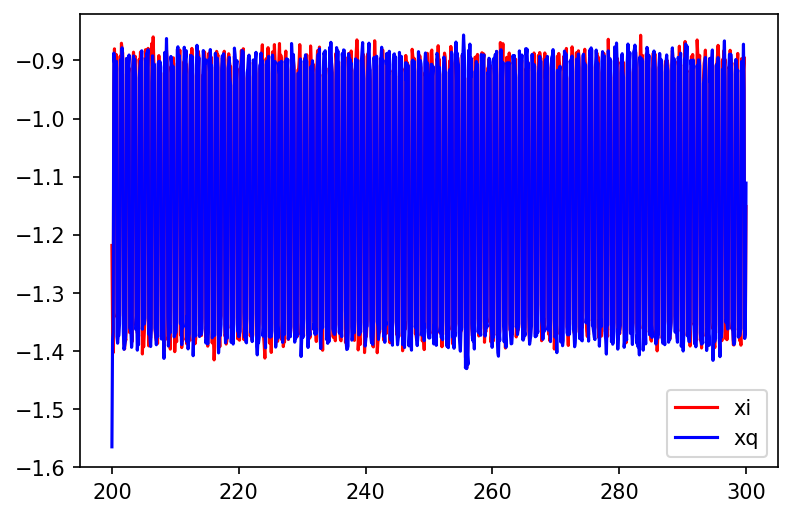

In [10]:
#####################
### VNA Mode Demo ###
#####################
# In this mode, the PFB + DDS + CIC are amplitude/phase calibrated by setting the cal = True flag.
# Once calibration is completed for a given frequency range, cal = False will keep the same calibration data to apply
# for subsequent measurements.
#
# NOTE: If the frequency range/resolution are changed for the sweep, calibration should be repeated.
#

# Calibration flag.
cal = True

# Individual Spectrum flag.
spectrum = False

# Quantization.
soc.pfb_in.qout(8)

# DDS + CIC Output Selection..
soc.ddscic.dds_outsel(outsel="product")

# Set Decimation value.
soc.ddscic.decimation(2)

# Sampling frequency.
fs = soc.pfb_in.get_fb()/soc.ddscic.get_decimate()

# Frequency resolution of input/output.
print('Input DF: {} Hz, Output DF: {} Hz'.format(soc.ddscic.DF_DDS,soc.gen.DF*1000*1000))
print('Ratio: {}'.format(soc.ddscic.DF_DDS/(soc.gen.DF*1000*1000)))
print('')

# Frequency range and gain.
g = 0.5
N = 1000
f0 = 200
#f1 = f0 + (N-1)*soc.fcIn
f1 = f0 + 100

# Frequency vector.
f = np.linspace(f0,f1,N)

# Main loop...
# Main loop...
xi_v = np.zeros(N)
xq_v = np.zeros(N)
ai_v = np.zeros(N)
fi_v = np.zeros(N)
fic_v = np.zeros(N)

# Set phase/gain vector to 0 for calibration.
if cal:
    fi0_v = np.zeros(N)
    
for i in np.arange(len(f)):
    fk = f[i]
    fi0 = fi0_v[i]
    
    if cal:
        g0 = g
    else:
        g0 = g/g0_v[i]    
    
    # Quantize frequency to DDS resolution.
    fq = int(fk/soc.ddscic.DF_DDS_MHZ)*soc.ddscic.DF_DDS_MHZ

    # Find channel on PFB.
    K = freq2ch(fs=soc.pfb_in.get_fs(), f=fk, N=soc.pfb_in.N)

    # Compute DDS frequency.    
    fdds = (fq - (ch2freq(fs=soc.pfb_in.get_fs(), k=K, N=soc.pfb_in.N)))*1000*1000
    
    # Un-mask channel.
    soc.chsel.set_single(K)
    
    # Set DDS frequency.
    soc.ddscic.set_ddsfreq(ch_id=K, f=fdds)
            
    # Set output frequency.
    soc.gen.set(f=fq,fi=-fi0,g=g0)
    
    [xi,xq] = soc.stream.get_data(nt=1,idx=soc.chsel.ch2idx(K))    
    x = xi + 1j*xq      
    
    i0 = 1000
    i1 = -1000
    iMean = xi[i0:i1].mean()
    qMean = xq[i0:i1].mean()
    ai = np.abs(iMean + 1j*qMean)
    fi = np.angle(iMean + 1j*qMean)
    xi_v[i] = iMean
    xq_v[i] = qMean
    ai_v[i] = ai
    fi_v[i] = fi       

    if spectrum:
        w = np.hanning(len(x))
        xw = x*w
        F = (np.arange(len(x))/len(x)-0.5)*fs*1000
        Y = fftshift(fft(xw))

        plt.figure(1,dpi=150)
        plt.plot(F,20*np.log10(abs(Y)))
        plt.title("Spectrum for channel K = %d" %K);
        plt.xlabel("F [kHz]");
    
    print('i = {}, fin = {:.4f} MHz, fdds = {:0>5.2f} kHz, K = {}, fout = {:.2f} MHz, fi = {: .3f}, fi0 = {: .3f}'\
          .format(i,fq,fdds/1000,K,soc.gen.get(),fi, fi0))    
    

# Amplitude vs Frequency.
# Real vs Imaginary part.
plt.figure(2,dpi=150)
plt.plot(f,20*np.log10(ai_v))
plt.title('ai vs f');
plt.xlabel('F [MHz]');
plt.ylabel('A [dB]');
plt.ylim([0,80]);

# Phase vs Frequency.
#[fmin, fimin] = findPeak(f,-fi_v,xmax=204.06)
#[fmax, fimax] = findPeak(f,fi_v,xmin=204.06)
#print('df = {} kHz, dt = {} us'.format(1000*(fmax-fmin),1/(fmax-fmin)))
plt.figure(3,dpi=150)
plt.plot(f,fi_v,'-o',label='fi')
plt.title('fi vs f')
#plt.legend()
#plt.plot(fmin, -fimin,'*r')
#plt.plot(fmax, fimax,'*r')

# Real vs Imaginary part.
plt.figure(4,dpi=150)
plt.plot(xi_v,xq_v)
plt.title('xi vs xq')
plt.gca().set_aspect('equal')

plt.figure(5,dpi=150)
plt.plot(f,xi_v,'r')
plt.plot(f,xq_v,'b')
plt.legend(['xi','xq'])

# Save fi0/g0 table for compensation.
if cal:
    fi0_v = fi_v
    g0_v = ai_v/np.min(ai_v)

In [ ]:
soc.dacs

In [ ]:
fs=500e3

In [ ]:
ts = 1/fs

In [ ]:
ts*10000

In [ ]:
soc.axi_dma_0.recvchannel.idle

In [ ]:
rf_config = soc.ip_dict['usp_rf_data_converter_0']['parameters']

In [ ]:
rf_config